# Fiber analysis - the power of filters/convolutions

In [1]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import dxchange
import scipy.ndimage

spefile module not found
EdfFile module not found


### Load the micro-CT scan

The scanning is stored in the default format for the scanner vendor. It is not a standard format, but the **dxchange** package contains I/O functions to handle this format.

In [2]:
data = "/home/kazi/Works/Dtu/deep-learning-experimental-3D-image/Week-2/data/fiber/fiber_2022-11-03_164720/tomo-A/fiber_tomo-A_recon.txm"

In [3]:
vol = dxchange.read_txrm(data)
print('--- Volume loaded ---')
print(vol)

--- Volume loaded ---
(array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,


In [4]:
print(vol[1]['pixel_size'])
print(vol[0].min())
print(vol[0].max())
print(vol[0].shape)

4.435972690582275
0
64822
(1008, 1024, 1004)


### Initial inspection

Note: The volume is actually a 2-element tuple (an immutable list), where the first element contains a big matrix and the second contains a dictionary with various header information.

For now the dimensions of the volume and the size of the voxel is the most basic and relevant information to store

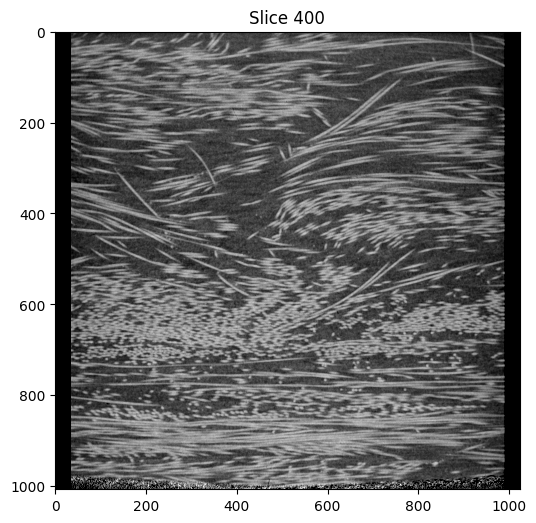

In [5]:
## --- Set-up header --- ## 
imgDim = vol[0].shape # Volume dimensions - use np.shape() on the first tuple element
pixSz =  vol[1]['pixel_size'] # Voxel size - use the dictionary of the second tuple element
## --------------------- ##

# The volume is isotropic, so we can just repeat the pixSz to all 3 dimensions and convert to mm unit
imgSpace = np.array([pixSz, pixSz, pixSz]) * 1e-3 # mm

# Getting a sense of the intensity range is also a good idea, although it is not as good as seeing the histogram!

## --- Min and Max value --- ## 
minVal = 0
maxVal = 900
## ----------------------- ##

# Showcase
## --- Pick a slice to show --- ## 
sNo = 400
## --------------------- ##

cView = [30000,45000]
%matplotlib inline
plt.figure(figsize=(6, 6))
plt.imshow(vol[0][...,sNo], cmap='gray', vmin=cView[0], vmax=cView[1])
plt.title('Slice ' + str(sNo))
plt.show()

### Crop-out
Crop out a piece of the dataset of around size 400 x 400 x 400:

This is ALWAYS a sound idea when
- A: Showcasing an analysis live AND
- B: Developping an analysis pipeline

Once the premise for the pipeline has been established, one can always go back an process the full volume

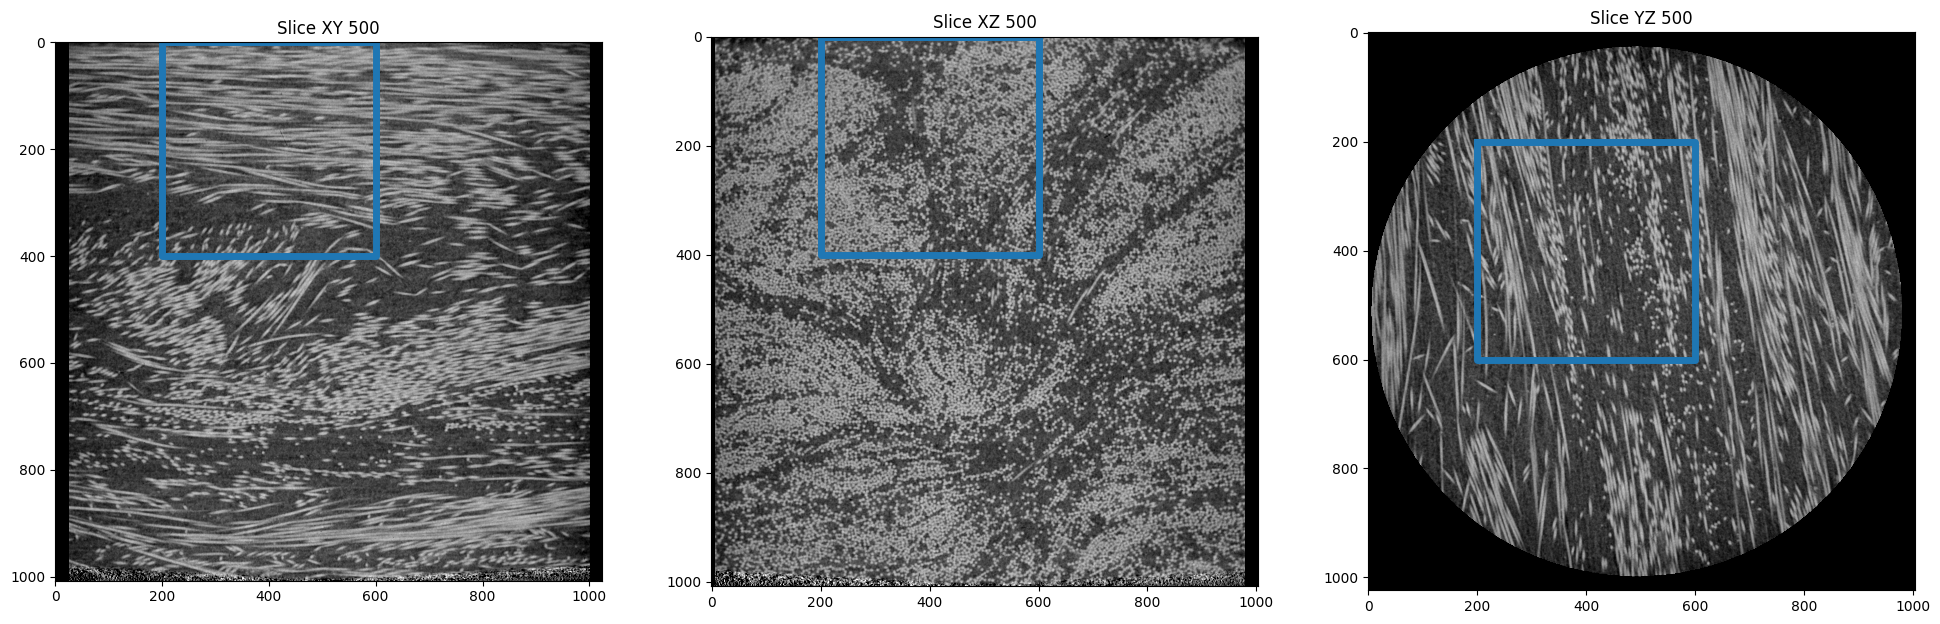

In [6]:
## ------------ Cropout -----------------##
x1 = 0
x2 = 400
y1 = 200
y2 = 600
z1 = 200
z2 = 600
boxSelect = np.array([[x1,y1,z1],[x2,y2,z2]]) #selection box [x,y,z]
sNo = 500 # slice for showcasing
## ------------------------------------- ##

# Show volume slices.
fig, ax = plt.subplots(1,3,figsize=(24,8))
ax[0].imshow(vol[0][...,sNo], cmap='gray', vmin=cView[0], vmax=cView[1])
ax[0].plot(boxSelect[[0,1,1,0,0],1],boxSelect[[0,0,1,1,0],0], linewidth=5.0)
ax[0].set_title('Slice XY ' + str(sNo))

ax[1].imshow(np.squeeze(vol[0][:,sNo,:]), cmap='gray', vmin=cView[0], vmax=cView[1])
ax[1].plot(boxSelect[[0,1,1,0,0],2],boxSelect[[0,0,1,1,0],0], linewidth=5.0)
ax[1].set_title('Slice XZ ' + str(sNo))

ax[2].imshow(np.squeeze(vol[0][sNo,:,:]), cmap='gray', vmin=cView[0], vmax=cView[1])
ax[2].plot(boxSelect[[0,1,1,0,0],2],boxSelect[[0,0,1,1,0],1], linewidth=5.0)
ax[2].set_title('Slice YZ ' + str(sNo))

# Cropout
volCrop = vol[0][boxSelect[0,0]:boxSelect[1,0] , boxSelect[0,1]:boxSelect[1,1] , boxSelect[0,2]:boxSelect[1,2]]

# Flip to 'normal' BEAM VIEW orientation
volCrop = np.transpose(volCrop,(1,2,0))
volCrop = np.flip(volCrop,axis=0)

### Export crop-out for further inspection

It is always nice to make an inspection of the volume in interactive viewer!

Export the cropout and inspect it in ITK-snap

In [7]:
# Store crop-out in a more standard volumetric format (.nii)

## --- Where to export --- ##
outFolder = 'data/fiber/' # must be a folder where you have write acess!
cropFName = 'crop-out.nii' # remember .nii file-ending! 
## ----------------------- ##

# Set header information
origin = np.array([0,0,0])
affine = np.zeros((4,4))
affine[0:3,3] = origin
affine[0,0] = imgSpace[0]
affine[1,1] = imgSpace[1]
affine[2,2] = imgSpace[2]

# Export
img_nii = nib.Nifti1Image(volCrop, affine)
nib.save(img_nii, outFolder + cropFName)

### Gradient estimation using filters/convolutions

An image doesn't have a true gradient (in a mathematical sense), but nevertheless the local gradient in x,y (and z) direction in any voxel can estimated in many different ways

- 1: Forward (or backward, central) difference approximation (which reduces the dimension by 1, in the selected direction)
- 2: Approximation using a Sobel (or Prewitt) kernel convolution (image filtering)
- 3: Approximation using any gradient kernel convolution (image filtering, but using the derivative of Gaussian function)

Here we will just the use the Sobel kernel
- https://en.wikipedia.org/wiki/Sobel_operator
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.sobel.html

**NB:** For simplicity we will just calculate the gradient in two directions, as that makes the subsequent steps a little simpler - which the purpose of this exercise is fine!


Text(0.5, 1.0, 'Sobel V_Y')

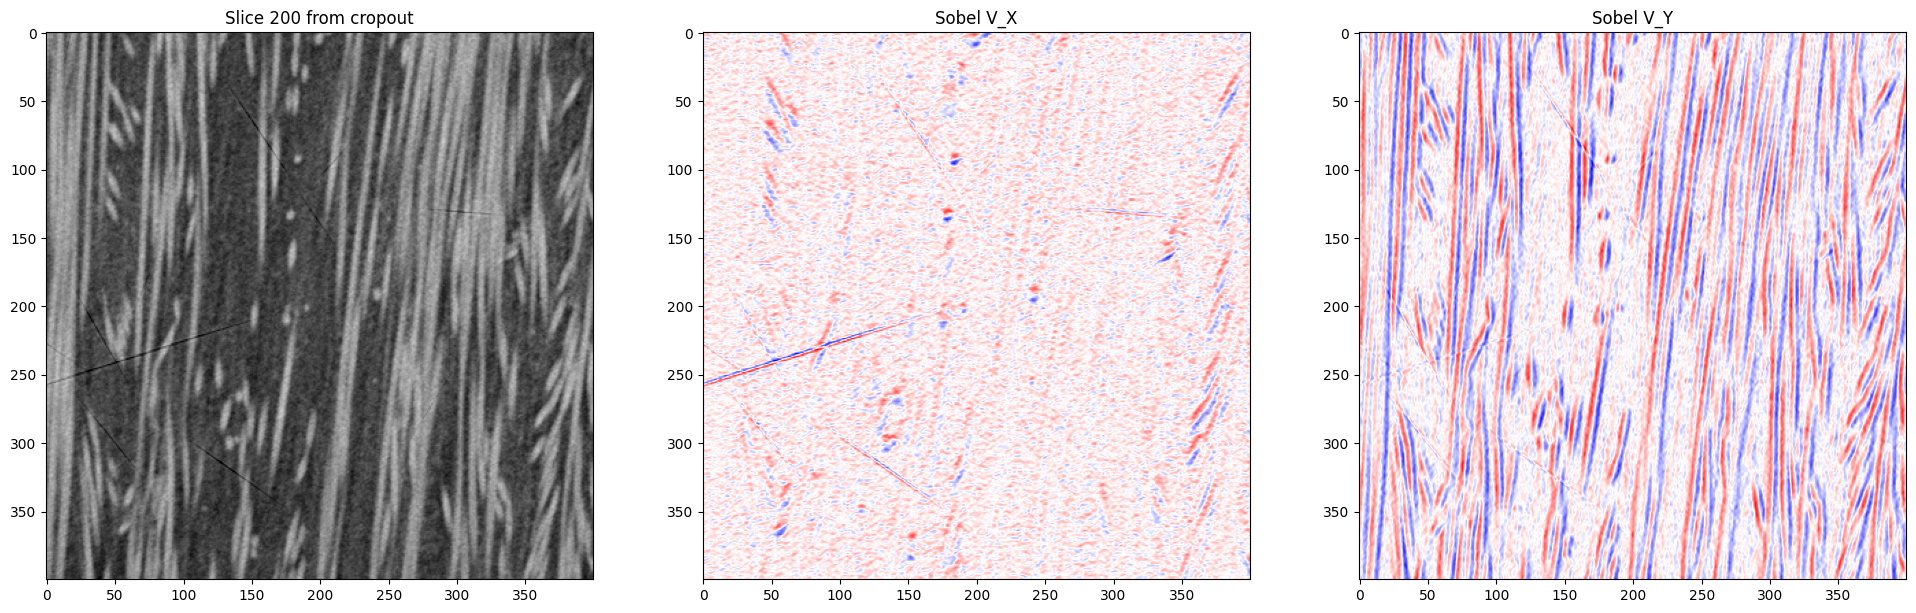

In [8]:
# First we cast the cropped volume to a non-integer format, as we need to be able to handle negative and decimal values!
from scipy import ndimage, datasets

volCrop = np.float32(volCrop)

ascent = volCrop# datasets.ascent().astype('int32')

## --- Apply Sobel filter --- ##
Vx_sob = ndimage.sobel(ascent, 0)
Vy_sob = ndimage.sobel(ascent, 1)
## -------------------------- ##

# Showcase the result

## --- Choose a slice from the crop-out --- ##
sNo = 200
## ---------------------------------------- ##

fig, ax = plt.subplots(1,3,figsize=(24,12))
ax[0].imshow(volCrop[...,sNo], cmap='gray', vmin=30000, vmax=45000)
ax[0].set_title('Slice ' + str(sNo) + ' from cropout')

ax[1].imshow(Vx_sob[...,sNo], cmap='bwr')
ax[1].set_title('Sobel V_X')

ax[2].imshow(Vy_sob[...,sNo], cmap='bwr')
ax[2].set_title('Sobel V_Y')


### Orientation analysis

The gradient is estimated for each direction/axis of the image. The information can be 'combined' as the gradient magntiude and the relationship between Vx and Vy tells us something about the edge orientation. These non linear combinations from the two filters yields remarkable results.


Text(0.5, 1.0, 'Gradient direction')

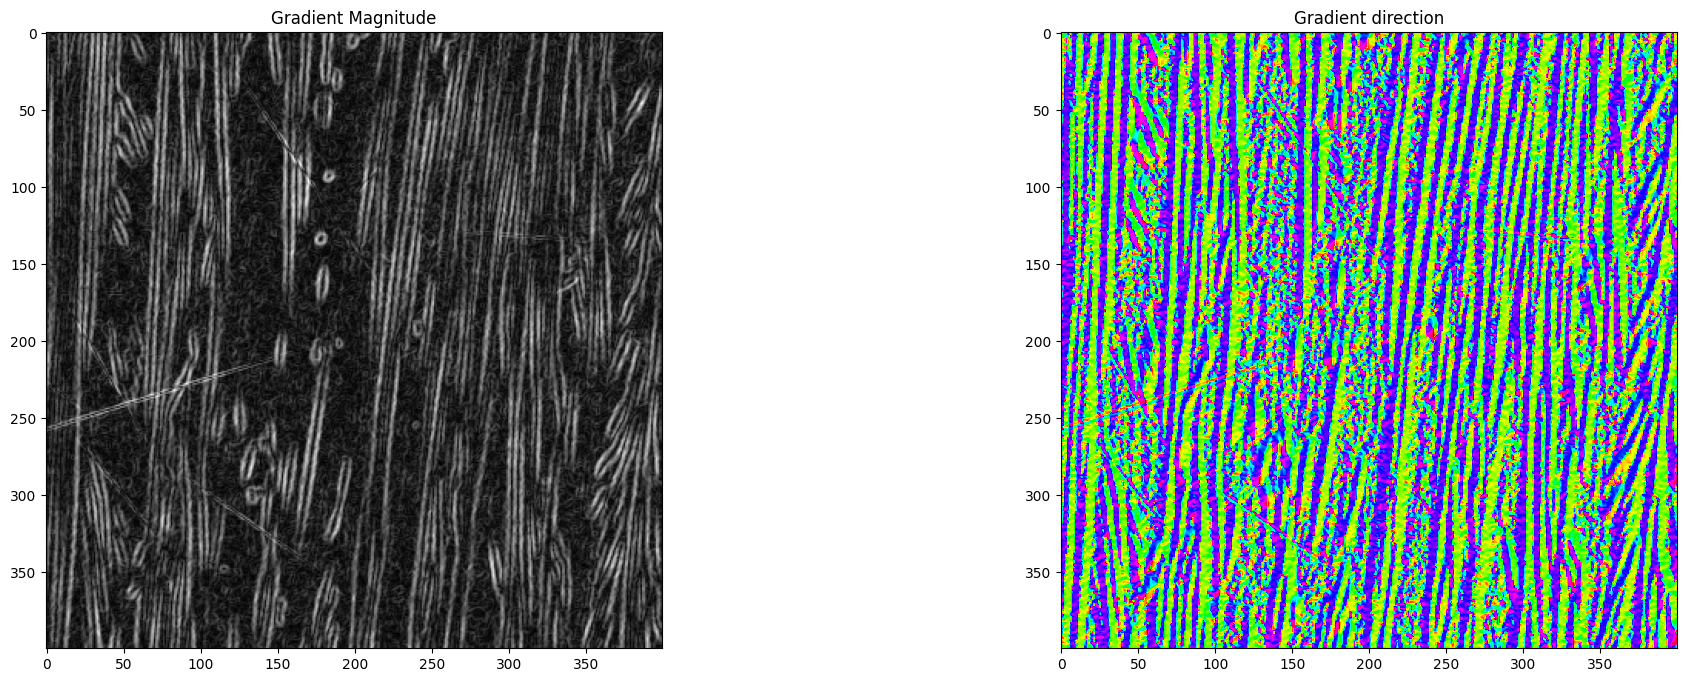

In [9]:
# First we do two non-linear combinations of the filter outputs

# Gradient magnitude
Vmag = np.sqrt(np.power(Vx_sob,2) + np.power(Vy_sob,2))

# Gradient direction
Vang = np.arctan2(Vy_sob,Vx_sob)

# Showcase
fig, ax = plt.subplots(1,2,figsize=(24,8))
ax[0].imshow(Vmag[...,sNo], cmap='gray')
ax[0].set_title('Gradient Magnitude')

ax[1].imshow(Vang[...,sNo], cmap='hsv')
ax[1].set_title('Gradient direction')

### Classification of horizontal and vertical fibers

Further combination of the two volumes can provide a simple but rough! classifier into vertical and horizontal fiber populations.

NB: What is considered vertical and horizontal depends on how you applied the Sobel filter.

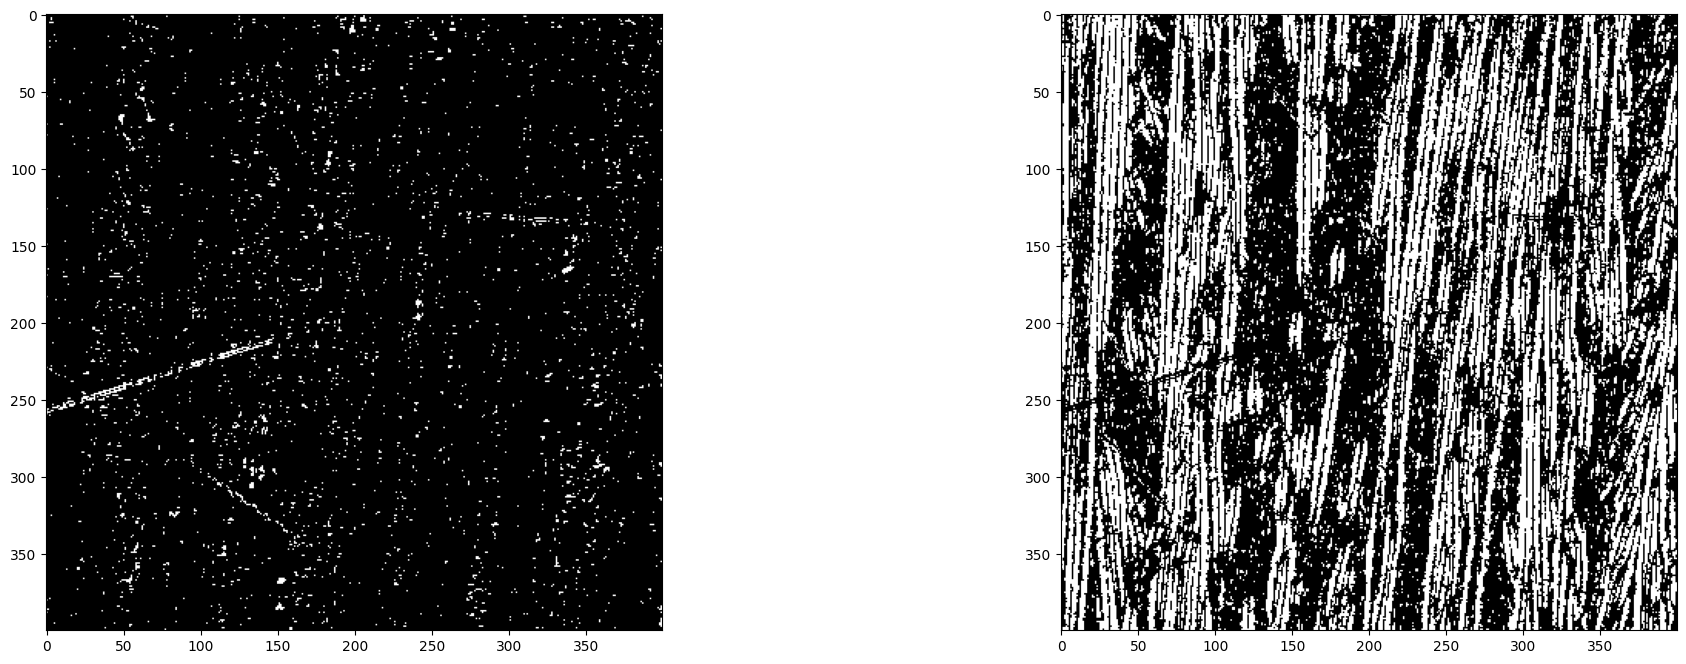

In [11]:
# -- vertical fibers - #
th = 16000
Vmask1 = np.logical_and(Vang < 0.5 , Vang > -0.5)
Vmask2 = np.logical_or(Vang > np.pi-0.5 , Vang < -np.pi+0.5)
Vmask3 = np.logical_or(Vmask1, Vmask2)
Vmask4 = Vmag > th
Vmask_vert = np.logical_and(Vmask3, Vmask4)

# -- horizontal fibers - #
Vmask1 = np.logical_and(Vang > 1 , Vang < 2)
Vmask2 = np.logical_and(Vang > -2 , Vang < -1)
Vmask3 = np.logical_or(Vmask1, Vmask2)
Vmask4 = Vmag > th
Vmask_horz = np.logical_and(Vmask3, Vmask4)

# - classification volume - #
Vclass = np.zeros(shape=np.shape(volCrop), dtype=np.uint8)
Vclass[Vmask_vert] = 1
Vclass[Vmask_horz] = 2

# Showcase
fig, ax = plt.subplots(1,2,figsize=(24,8))
ax[0].imshow(Vmask_vert[...,sNo], cmap='gray')
ax[1].imshow(Vmask_horz[...,sNo], cmap='gray')

In [ ]:
# Export both volumes for interactive exploration in ITK-snap

## --- Where to export --- ##
outFolder = 'data/' # must be a folder where you have write acess!
magFName = 'mag.nii' # remember .nii file-ending!
angFName = 'ang.nii' # remember .nii file-ending!
classFname = 'class.nii' #remember .nii file-ending
## ----------------------- ##

# Convert angles to an RGB-colormap based on the angles
from matplotlib import cm
cMapRes = 56 # Resolution of the circular colormap
cMap = cm.get_cmap('hsv',cMapRes)
cMapArray = cMap(np.linspace(0,1,cMapRes))

# Angular spacing
cVec = np.linspace(-np.pi, np.pi, cMapRes)

# Angle-2-color mapping
colIdx = np.argmin(np.abs(np.transpose(np.tile(Vang.flatten(),(cMapRes,1))) - np.tile(cVec,(np.size(Vang),1))),axis=1)
colMap = cMapArray[colIdx,0:3]
colMap = np.reshape(colMap,newshape=(np.size(Vang,0),np.size(Vang,1),np.size(Vang,2),3))

# We also threshold the colormap based on the gradient magnitude - just to make it a little more nice!
mask = Vmag > th
colMap[:,:,:,0] = np.multiply(colMap[:,:,:,0], mask)
colMap[:,:,:,1] = np.multiply(colMap[:,:,:,1], mask)
colMap[:,:,:,2] = np.multiply(colMap[:,:,:,2], mask)

# Convert to RGB uint8
colMap = np.uint8(colMap*255)

# Export
# just re-use the header - 'affine' - from before
img_nii = nib.Nifti1Image(Vmag, affine)
nib.save(img_nii, outFolder + magFName)

img_nii = nib.Nifti1Image(Vclass, affine)
nib.save(img_nii, outFolder + classFname)

img_nii = nib.Nifti1Image(colMap, affine)
nib.save(img_nii, outFolder + angFName)

**Tips for ITK-snap:**
- The magnitude volume can be loaded as "an Additional Image". Adjust colormap, transparency settings etc. in the Layer Inspection under the ''Tools'' tab
- The classification volume can be loaded as a "Segmentation".
- The angular colormap can be loaded as "an Additional Image". Under the Layer Inspector > General > "How to visualize multiple image components", choose RGB display.